In [4]:
import warnings
warnings.filterwarningsnings('ignore')

In [5]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

### Loading the Dataset

In [6]:
lfw_people = fetch_lfw_people('data', min_faces_per_person=70, resize=0.4)

In [9]:
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [10]:
X = lfw_people.data
n_features = X.shape[1]

In [11]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [12]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print( "n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [13]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

### Split into a Training and Testing Set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
n_components = 150

print(f"Extracting the top {n_components} from {X_train.shape[0]} faces")

t0 = time()

# Create an instance of PCA
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

pca = pca.fit(X_train)

print(f"Done in {time() - t0}")

Extracting the top 150 from 966 faces
Done in 6.894550085067749


In [18]:
eigenfaces = pca.components_.reshape((n_components, h, w))

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"Done in {time() - t0}")

Done in 0.015004873275756836


### Train a SVM Classification Model

In [19]:
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best Estimator Found By Grid Search")
print(clf.best_estimator_)

Best Estimator Found By Grid Search
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [20]:
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.97      0.81      0.88        36

         accuracy                           0.85       322
        macro avg       0.90      0.73      0.79       322
     weighted avg       0.87      0.85      0.85       322



In [21]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  7   1   0   5   0   0   0]
 [  1  52   0   7   0   0   0]
 [  1   2  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   3   0   4   1   7   0]
 [  0   1   1   5   0   0  29]]


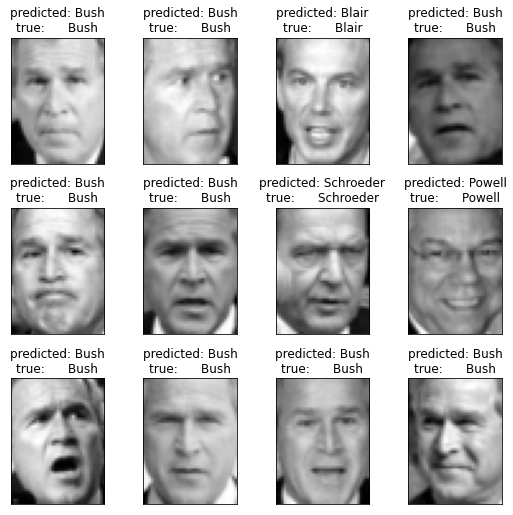

In [22]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())
        
# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

pl.show()        

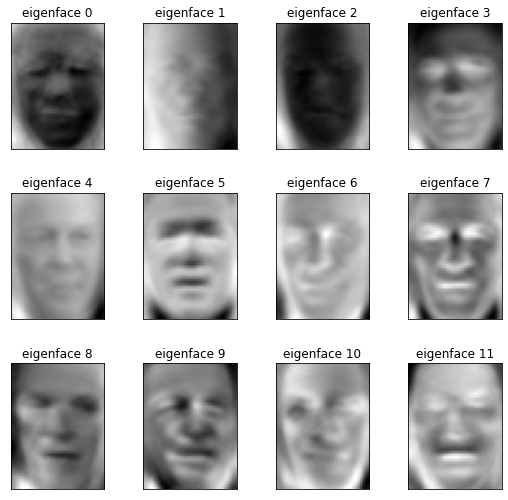

In [23]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()